In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import entropy
from tqdm.notebook import tqdm
from rdkit import Chem

In [2]:
LIB_SIZE = 5021

# Обработка результатов GNPS

In [3]:
path = 'clustered_spectra2/'

### Summary ###

`summary` устанавливает соответствие между веществом и номером его компоненты связности

Колонки:

- `id` -- порядковый номер вещества (нумерация с 0)
- `component` -- номер компоненты связности, в котором лежит вещество. Нумерация с 0, `-1` -- для изолированных вершин
- `mass` -- масса вещества

In [4]:
summary = pd.read_csv(path + 'pnp.clustersummary', sep='\t')[['componentindex', 'parent mass']]
summary.rename(columns={'componentindex' : 'component', 'parent mass' : 'mass'}, inplace=True)
summary.index.name = 'id'
summary.loc[summary.component != -1, 'component'] -= 1

summary

,component,mass
id,,
0,131,487.301
1,6,568.370
2,8,522.131
3,122,637.279
4,6,648.376
...,...,...
5016,-1,4639.470
5017,-1,4936.340
5018,-1,5801.740


### Edges ###

`edges` содержит описание всех ребер, соединяющих похожие с точки зрения GNPS вещества

Колонки:
- `id1`, `id2` -- номера вершин, соединенных ребром
- `delta_mz` -- разница в массе веществ: `delta_mz = mass(id1) - mass(id2)`
- `cosine` -- степень сходства между спектрами веществ (оценка GNPS): `0 <= cosine <= 1`. Нас интересуют пары с `cosine >= 0.73`
- `component` -- номер компоненты связности, в котором это ребро
- `note` -- предположительная разница в атомном составе веществ (с точки зрения GNPS)

In [5]:
edges = pd.read_csv(path + 'pnp.selfloop', sep='\t')
edges.drop(columns=['OtherScore', 'MEH'], axis=1, inplace=True)
edges = edges.rename(columns={'CLUSTERID1' : 'id1', 'CLUSTERID2' : 'id2', 'DeltaMZ' : 'delta_mz', 
                              'Cosine' : 'cosine', 'ComponentIndex' : 'component', 'EdgeAnnotation' : 'note'})
edges = edges[edges.component != -1]
edges.component -= 1
edges.id1 -= 1
edges.id2 -= 1

edges

,id1,id2,delta_mz,cosine,component,note
0,1075,1108,39.011,0.9258,0,C2HN
1,7,1040,39.011,0.9258,0,C2HN
2,1040,1075,0.000,0.8571,0,
3,7,1075,39.011,0.9258,0,C2HN
4,1040,1108,39.011,0.9258,0,C2HN
...,...,...,...,...,...,...
14904,88,301,-594.234,0.8165,519,
14905,1114,1116,2.016,1.0000,520,H2
14906,571,3074,-14.020,1.0000,521,methanol (-H2O):CH2
14907,571,3110,-28.030,0.9545,521,CH2N:C2H4


### Pnps ###

`pnps` -- основная структура, содержащая всю информацию о веществах из pnpdatabase и сходстве между ними. Представляет собой неориентированный граф, в котором вершины -- PNP, а ребра соединяют похожие вещества.

**Вершины:** нумеруются в соответствии с нумерацией PNP. Атрибуты:

- `file` -- имя .mol файла со структурой вещества
- `name` -- название PNP
- `formula` -- химическая формула
- `mass` -- масса PNP
- `graph_aa` -- `nx.MultiGraph()` из аминокислот вещества. Атрибуты:
    
    - `is_multiedges` --присутствуют ли кратные ребра
    - `structure` -- структура графа (linear, cyclic, branch-cyclic, ...)
    
        **Вершины:** нумеруются с нуля. Атрибуты:
        
        - `formula` -- химическая формула аминокислоты
        - `mass` -- масса аминокислоты

**Рёбра:** соединяют PNP, чьи спектры похожи с точки зрения GNPS. Атрибуты:

- `num` -- номер ребра в таблице `edges`

In [6]:
pnps = nx.Graph()

with open('pnpdatabase/pnp_AAGraphs.txt', 'r') as f:
    for id_ in range(LIB_SIZE):
        filename, pnp_name = f.readline().split()
        _, _, chem_formula, _, _, mass = f.readline().split()
        mass = float(mass)
        _ = f.readline()
        *_, num_nodes = f.readline().split()
        num_nodes = int(num_nodes)
        
        pnp = nx.MultiGraph()
        
        for i in range(num_nodes):
            AA_num, AA_chem_formula, AA_mass = f.readline().split()
            AA_num = int(AA_num)
            AA_mass = float(AA_mass)
            pnp.add_node(AA_num, formula=AA_chem_formula, mass=AA_mass)
        
        *_, num_edges = f.readline().split()
        num_edges = int(num_edges)
        pnp_is_multiedges = False
        
        for i in range(num_edges):
            v1, _, v2 = f.readline().split()
            v1, v2 = int(v1), int(v2)
            if (v1 != v2):
                if (v1, v2) in pnp.edges:
                    pnp_is_multiedges = True
                pnp.add_edge(v1, v2)
        
        pnp.graph['is_multiedges'] = pnp_is_multiedges
        pnp_structure = f.readline()[:-1]
        pnp.graph['structure'] = pnp_structure
        
        pnps.add_node(id_, file=filename, name=pnp_name, formula=chem_formula, mass=mass, graph_aa=pnp)



In [20]:
for num, edge in edges.iterrows():
    pnps.add_edge(edge.id1, edge.id2, num=num)

print(pnps)

Graph with 5021 nodes and 14909 edges


### Фильтрация ребер по `cosine` при необходимости ###

In [21]:
threshold = 0.73 # default : 0.73

for e in pnps.edges():
    if edges.loc[pnps.edges[e]['num'], 'cosine'] < threshold:
        pnps.remove_edge(*e)

print(pnps)

Graph with 5021 nodes and 14909 edges


### Компоненты связности

In [11]:
def ccs(graph):
    return sorted([sorted(list(_)) for _ in nx.connected_components(nx.Graph(graph))])

In [12]:
GNPS_ccs = ccs(GNPS)

In [13]:
with open('GNPS_clusters.txt', 'w') as f:
    for cc in GNPS_ccs:
        f.write(' '.join([str(i) for i in cc])+'\n')

# PNP structure analysis

In [22]:
for pnp_id in range(1, 5022):
    pnp = GNPS.nodes[pnp_id]['structure']
    summary.loc[pnp_id, 'multiedges'] = pnp.graph['multiedges']
    summary.loc[pnp_id, 'structure'] = pnp.graph['structure']

,component,mass,is_multiedges,structure
id,,,,
0,131,487.301,False,cyclic
1,6,568.370,False,cyclic
2,8,522.131,False,branch-cyclic
3,122,637.279,False,linear
4,6,648.376,True,branch-cyclic
...,...,...,...,...
5016,-1,4639.470,False,linear
5017,-1,4936.340,False,branch-cyclic
5018,-1,5801.740,False,linear


In [9]:
def pnp_structure(pnp):
    nn = pnp.number_of_nodes()
    ne = pnp.number_of_edges()
    degs = [deg for node, deg in pnp.degree]
    c = Counter(degs)
    if pnp.graph['multiedges'] == False:
        pnp_copy = nx.Graph(pnp)
        if nx.is_isomorphic(pnp_copy, nx.cycle_graph(nn)): return 'cyclic'
        if nx.is_isomorphic(pnp_copy, nx.path_graph(nn)): return 'linear'
        if (nn == ne + 1):
            if nx.is_isomorphic(pnp_copy, nx.star_graph(nn - 1)): return 'star'
            return 'tree'
        if (nn == ne):
            if c[1] == 1: return 'branch-cyclic'
            return 'poly-branch-cyclic'
        if (nn == ne - 1): return 'bicyclic'
        return 'complex'
    if (nn == ne) and (c[1] == 1): return 'branch-cyclic'
    if (nn == 2): return 'small'
    return 'complex'

In [10]:
for pnp_id in range(1, 5022):
    pnp = GNPS.nodes[pnp_id]['structure']
    my_struct = pnp_structure(pnp)
    GNPS.nodes[pnp_id]['structure'].graph['structure'] = my_struct
    summary.loc[pnp_id, 'my_structure'] = my_struct

In [11]:
for i in tqdm(range(len(edges))):
    id1, id2 = edges.loc[i, ['ID1', 'ID2']]
    struct1 = summary.loc[id1, 'my_structure']
    struct2 = summary.loc[id2, 'my_structure']
    if struct1 == struct2:
        edges.loc[i, 'structure_change'] = 'No'
    else:
        edges.loc[i, 'structure_change'] = struct1 + ' -> ' + struct2

  0%|          | 0/14909 [00:00<?, ?it/s]

In [12]:
edges.groupby(['structure_change']).count().sort_values('ID1', ascending=False)

,ID1,ID2,DeltaMZ,Cosine,Component,Note
structure_change,,,,,,
No,12592,12592,12592,12592,12592,12592
linear -> tree,522,522,522,522,522,522
branch-cyclic -> poly-branch-cyclic,490,490,490,490,490,490
tree -> linear,456,456,456,456,456,456
cyclic -> branch-cyclic,291,291,291,291,291,291
branch-cyclic -> cyclic,107,107,107,107,107,107
poly-branch-cyclic -> branch-cyclic,68,68,68,68,68,68
cyclic -> poly-branch-cyclic,60,60,60,60,60,60
complex -> branch-cyclic,53,53,53,53,53,53


In [13]:
edges[edges.structure_change != 'No']

,ID1,ID2,DeltaMZ,Cosine,Component,Note,structure_change
5,3412,1109,162.068,0.8165,1,,cyclic -> branch-cyclic
398,3855,3889,29.020,0.7624,6,N2H:HN2:CH3N,cyclic -> branch-cyclic
446,3873,3889,15.000,0.9230,6,,cyclic -> branch-cyclic
460,350,3889,15.000,0.8026,6,,cyclic -> branch-cyclic
462,3878,3889,14.020,0.9436,6,methanol (-H2O):CH2,cyclic -> branch-cyclic
...,...,...,...,...,...,...,...
14823,3035,2875,219.090,0.9809,471,,cyclic -> branch-cyclic
14842,2870,958,14.010,0.9092,482,tertiary amine:N:methanol (-H2O):CH2,cyclic -> branch-cyclic
14891,2124,3063,17.993,0.9608,511,,poly-branch-cyclic -> branch-cyclic
14893,2124,2152,1.998,0.9608,511,isotope_34S:isotope_37Cl:isotope_81Br,poly-branch-cyclic -> branch-cyclic


{'file': 'mols/QQS65-I.mol', 'name': 'Nodulapeptin_899_Nodulapeptin_899', 'formula': 'C47H61N7O11', 'mass': 899.443, 'multiedges': False, 'structure': 'poly-branch-cyclic'}
{'file': 'mols/QQS66-J.mol', 'name': 'Nodulapeptin_90_Nodulapeptin_901', 'formula': 'C47H63N7O9S', 'mass': 901.441, 'multiedges': False, 'structure': 'branch-cyclic'}


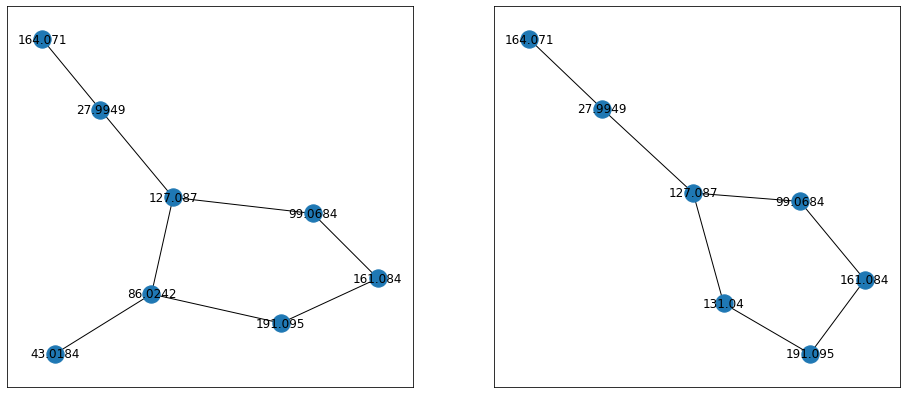

In [20]:
# TEMPORARY

pnp1 = GNPS.nodes[2124]['structure']
pnp2 = GNPS.nodes[2152]['structure']

print(pnp1.graph)
print(pnp2.graph)

fig = plt.figure(figsize = (16, 7))
l1 = {}
l2 = {}
for i in range(pnp1.number_of_nodes()):
    l1[i] = pnp1.nodes[i]['mass']
for i in range(pnp2.number_of_nodes()):
    l2[i] = pnp2.nodes[i]['mass']
subax1 = plt.subplot(121)
nx.draw_networkx(pnp1, labels=l1)
subax2 = plt.subplot(122)
nx.draw_networkx(pnp2, labels=l2)
plt.show()

In [14]:
summary.groupby(['structure', 'my_structure', 'multiedges']).count()

component  mass
structure     my_structure       multiedges                 
branch-cyclic branch-cyclic      False            1057  1057
                                 True              157   157
              linear             False              36    36
complex       bicyclic           False             199   199
              branch-cyclic      False             216   216
                                 True               13    13
              complex            False              59    59
                                 True              237   237
              cyclic             False              56    56
              linear             False              65    65
              poly-branch-cyclic False             193   193
              star               False              16    16
              tree               False             181   181
cyclic        cyclic             False            1257  1257
linear        linear             False            1265  1265
small         cyclic             False              11    11
              small              True                3     3

In [15]:
summary[summary.component != -1].groupby(['component', 'my_structure']).count().head(22)

mass  multiedges  structure
component my_structure                                   
1         branch-cyclic          4           4          4
          cyclic                 1           1          1
2         linear                71          71         71
3         cyclic                 3           3          3
4         branch-cyclic         15          15         15
5         linear                 5           5          5
6         branch-cyclic          1           1          1
          cyclic                19          19         19
7         bicyclic              65          65         65
          branch-cyclic        127         127        127
          complex                5           5          5
          cyclic               338         338        338
          linear                11          11         11
          poly-branch-cyclic     5           5          5
8         linear                11          11         11
9         branch-cyclic        100         100        100
          complex                6           6          6
          cyclic                 1           1          1
          poly-branch-cyclic    56          56         56
          tree                   1           1          1
10        branch-cyclic         17          17         17
          cyclic                 1           1          1

In [16]:
summary.head(10)

,component,mass,multiedges,structure,my_structure
ID,,,,,
1,132,487.301,False,cyclic,cyclic
2,7,568.370,False,cyclic,cyclic
3,9,522.131,False,branch-cyclic,branch-cyclic
4,123,637.279,False,linear,linear
5,7,648.376,True,branch-cyclic,branch-cyclic
6,449,703.391,False,complex,linear
7,100,676.261,False,complex,tree
8,1,663.293,False,branch-cyclic,branch-cyclic
9,-1,669.343,False,cyclic,cyclic


In [17]:
edges.head(10)

,ID1,ID2,DeltaMZ,Cosine,Component,Note,structure_change
0,1109,1076,39.011,0.9258,1,C2HN,No
1,1041,8,39.011,0.9258,1,C2HN,No
2,1076,1041,0.000,0.8571,1,,No
3,1076,8,39.011,0.9258,1,C2HN,No
4,1109,1041,39.011,0.9258,1,C2HN,No
5,3412,1109,162.068,0.8165,1,,cyclic -> branch-cyclic
6,4604,4624,28.030,0.8889,2,CH2N:C2H4,No
7,4646,4656,14.010,0.7778,2,tertiary amine:N:methanol (-H2O):CH2,No
8,4561,4566,16.030,0.7778,2,NH2:primary amine:CH4,No
9,4647,4653,14.010,1.0000,2,tertiary amine:N:methanol (-H2O):CH2,No


# Статистики

## DeltaMZ distribution

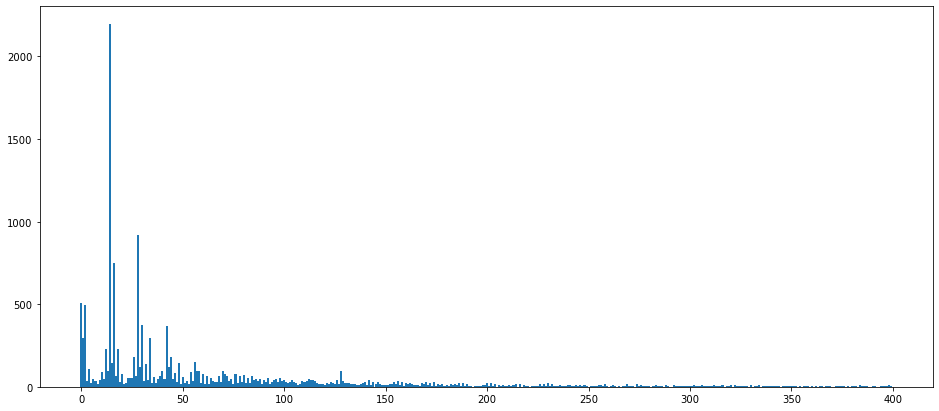

In [25]:
fig = plt.figure(figsize = (16, 7))
bin_sizes, _, _ = plt.hist(edges.DeltaMZ, bins=np.arange(-0.5, 400.5, 1))

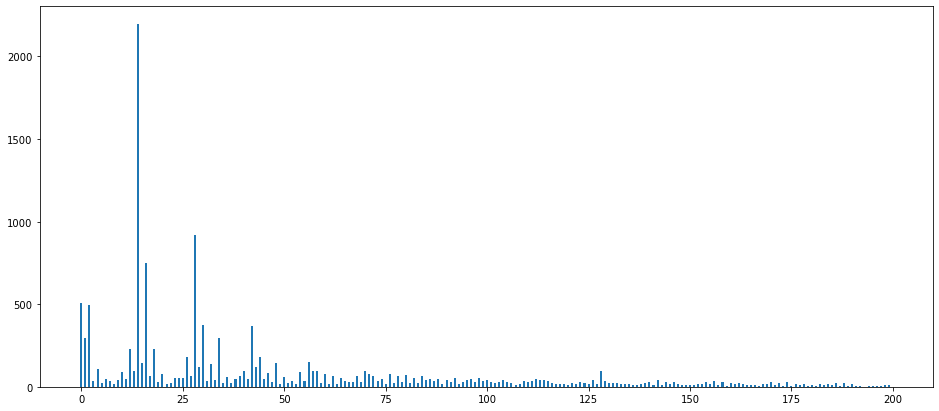

In [26]:
fig = plt.figure(figsize = (16, 7))
bin_sizes, _, _ = plt.hist(edges.DeltaMZ, bins=np.arange(-0.25, 200.25, 0.5))

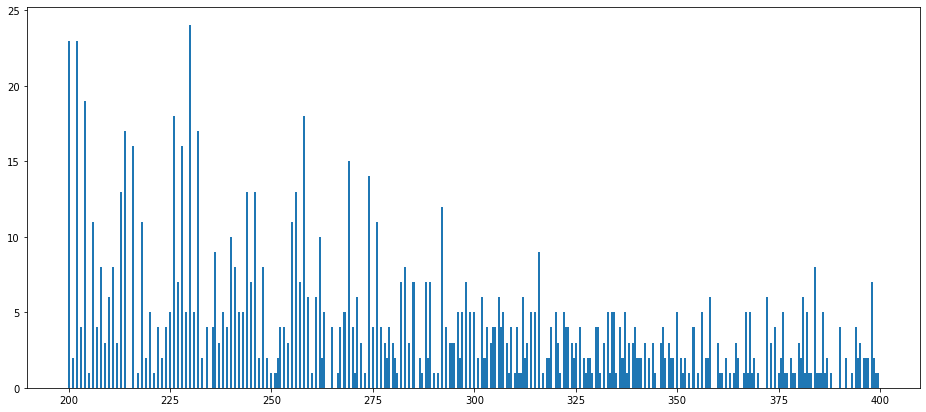

In [27]:
fig = plt.figure(figsize = (16, 7))
bin_sizes, _, _ = plt.hist(edges.DeltaMZ, bins=np.arange(199.75, 400.25, 0.5))

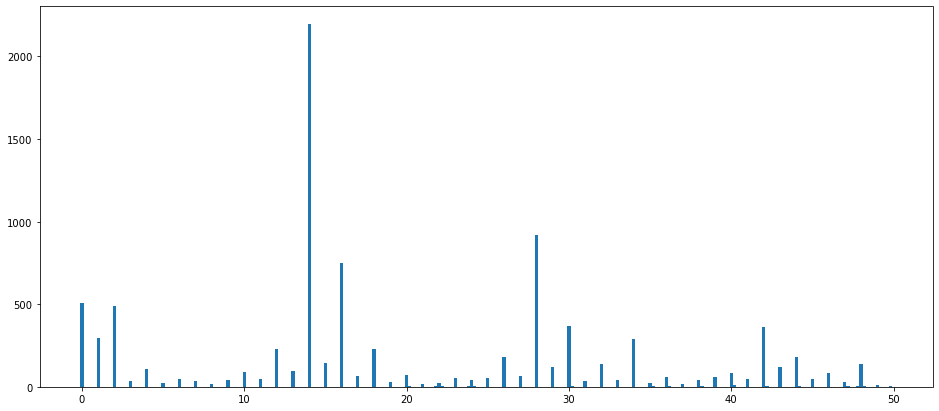

In [28]:
fig = plt.figure(figsize = (16, 7))
bin_sizes, _, _ = plt.hist(edges.DeltaMZ, bins=np.arange(-0.1, 50.1, 0.2))

In [29]:
DeltaMZ_distr = {}

for i in tqdm(np.arange(0, 1000, 0.02)):
    l = len(edges[abs(edges.DeltaMZ - i) < 0.01])
    if l > 0:
        DeltaMZ_distr[i] = l

DeltaMZ_distr

  0%|          | 0/50000 [00:00<?, ?it/s]

{0.0: 455,
 0.02: 25,
 0.04: 24,
 0.06: 1,
 0.08: 2,
 0.1: 1,
 0.96: 4,
 0.98: 133,
 1.0: 33,
 1.02: 1,
 1.04: 5,
 1.9000000000000001: 1,
 1.94: 6,
 1.96: 2,
 1.98: 136,
 2.0: 64,
 2.02: 240,
 2.04: 15,
 2.06: 1,
 2.94: 1,
 2.96: 1,
 2.98: 3,
 3.0: 7,
 3.02: 7,
 3.04: 14,
 3.06: 4,
 3.92: 2,
 3.94: 1,
 3.96: 4,
 3.98: 11,
 4.0: 46,
 4.0200000000000005: 22,
 4.04: 43,
 4.08: 1,
 4.94: 1,
 4.96: 9,
 4.98: 2,
 5.0: 2,
 5.0200000000000005: 4,
 5.04: 4,
 5.0600000000000005: 3,
 5.14: 1,
 5.9: 1,
 5.92: 5,
 5.94: 2,
 5.96: 18,
 5.98: 11,
 6.0200000000000005: 5,
 6.04: 3,
 6.08: 2,
 6.1000000000000005: 1,
 6.140000000000001: 1,
 6.94: 2,
 6.96: 20,
 6.98: 1,
 7.0: 3,
 7.0200000000000005: 6,
 7.0600000000000005: 3,
 7.12: 1,
 7.96: 6,
 7.98: 2,
 8.0: 6,
 8.040000000000001: 2,
 8.06: 5,
 8.96: 2,
 8.98: 5,
 9.0: 9,
 9.02: 7,
 9.040000000000001: 14,
 9.06: 8,
 9.9: 2,
 9.94: 1,
 9.96: 2,
 9.98: 29,
 10.0: 14,
 10.02: 41,
 10.040000000000001: 5,
 10.06: 3,
 10.08: 5,
 10.92: 2,
 10.94: 4,
 10.96:

In [30]:
DeltaMZ_distr_sort = sorted(DeltaMZ_distr.items(), key=lambda item: item[1], reverse=True)
DeltaMZ_distr_sort

[(14.02, 2079),
 (28.04, 776),
 (16.0, 604),
 (14.0, 565),
 (0.0, 455),
 (30.02, 259),
 (42.04, 251),
 (2.02, 240),
 (33.980000000000004, 165),
 (15.98, 159),
 (18.02, 140),
 (1.98, 136),
 (26.02, 136),
 (0.98, 133),
 (12.0, 129),
 (15.0, 100),
 (44.02, 100),
 (56.06, 96),
 (13.98, 93),
 (16.04, 93),
 (48.0, 82),
 (33.96, 80),
 (28.0, 76),
 (31.98, 65),
 (2.0, 64),
 (13.02, 62),
 (40.04, 59),
 (15.02, 58),
 (42.0, 54),
 (128.1, 53),
 (79.96000000000001, 52),
 (29.02, 47),
 (43.0, 47),
 (43.04, 47),
 (4.0, 46),
 (54.04, 46),
 (12.040000000000001, 45),
 (29.98, 45),
 (46.0, 45),
 (57.02, 44),
 (4.04, 43),
 (32.02, 42),
 (10.02, 41),
 (42.02, 41),
 (44.04, 41),
 (71.04, 41),
 (43.980000000000004, 40),
 (30.04, 38),
 (76.04, 38),
 (17.96, 37),
 (23.02, 35),
 (17.98, 34),
 (58.04, 34),
 (1.0, 33),
 (49.980000000000004, 33),
 (56.02, 32),
 (60.02, 31),
 (44.0, 30),
 (57.06, 30),
 (70.04, 30),
 (84.06, 30),
 (9.98, 29),
 (40.02, 29),
 (70.08, 29),
 (12.02, 28),
 (43.02, 28),
 (64.0, 28),
 (16

## In-class variance of the number of amino acids

In [29]:
AA_variance = []
min_cluster_size = 2

for cc in GNPS_ccs:
    a = np.array([GNPS.nodes[pnp_id]['structure'].number_of_nodes() for pnp_id in cc])
    size_, std_, min_, mean_, max_ = len(a), np.std(a), np.min(a), np.mean(a), np.max(a)
    if size_ < min_cluster_size:
        continue
    AA_variance.append([size_, std_, min_, mean_, max_])

AA_varinace = AA_variance.sort(key=lambda item : item[1], reverse=True)

print('Size | Std dev | Min |  Mean  | Max')
for line in AA_variance:
    print(f'{line[0]:4d} | {line[1]:7.3f} | {line[2]:3d} | {line[3]:6.3f} | {line[4]:3d}')

Size | Std dev | Min |  Mean  | Max
   3 |   3.399 |  15 | 19.667 |  23
   2 |   3.000 |  24 | 27.000 |  30
   2 |   2.500 |   8 | 10.500 |  13
   2 |   2.500 |  20 | 22.500 |  25
  11 |   2.339 |   5 |  8.273 |  11
  23 |   2.211 |   6 |  9.739 |  14
   3 |   2.160 |  10 | 13.000 |  15
   5 |   2.154 |   7 |  9.400 |  12
 551 |   2.112 |   3 |  5.909 |  11
   2 |   2.000 |   8 | 10.000 |  12
   2 |   2.000 |  15 | 17.000 |  19
   2 |   2.000 |  16 | 18.000 |  20
   8 |   1.900 |   5 |  6.125 |  11
   4 |   1.732 |   8 | 11.000 |  12
  39 |   1.693 |   8 | 10.487 |  13
   9 |   1.618 |   8 |  9.778 |  12
 164 |   1.590 |   3 |  5.549 |   9
  40 |   1.568 |  10 | 13.125 |  15
   2 |   1.500 |   5 |  6.500 |   8
   4 |   1.500 |   6 |  7.500 |   9
   2 |   1.500 |  18 | 19.500 |  21
   2 |   1.500 |   8 |  9.500 |  11
   2 |   1.500 |   6 |  7.500 |   9
   2 |   1.500 |  17 | 18.500 |  20
   3 |   1.414 |   6 |  8.000 |   9
  11 |   1.402 |   5 |  6.182 |   8
  19 |   1.398 |   5 |  7.21

   2 |   0.000 |  22 | 22.000 |  22
   4 |   0.000 |  15 | 15.000 |  15
   4 |   0.000 |  23 | 23.000 |  23
   2 |   0.000 |  20 | 20.000 |  20
   2 |   0.000 |  23 | 23.000 |  23
   2 |   0.000 |  26 | 26.000 |  26
   2 |   0.000 |  20 | 20.000 |  20
   2 |   0.000 |  20 | 20.000 |  20


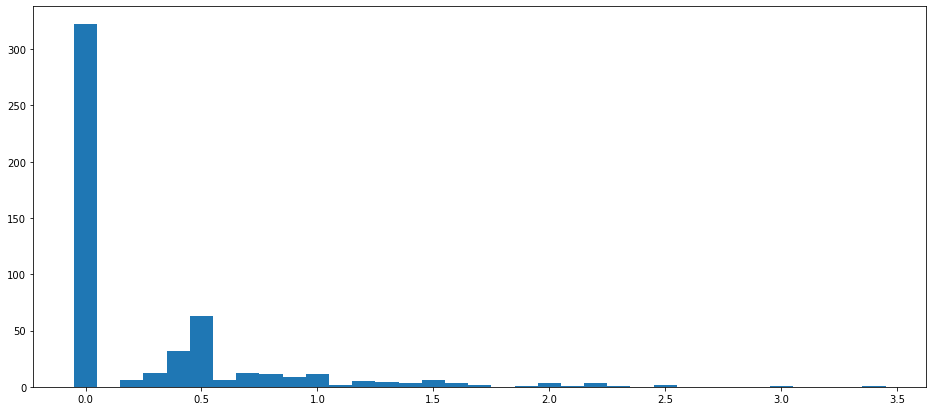

In [30]:
fig = plt.figure(figsize = (16, 7))
bin_sizes, _, _ = plt.hist([line[1] for line in AA_variance], bins=np.arange(-0.05, 3.55, 0.1))

# PNP compare

In [ ]:
# pnp_compare() TESTING

pnp1 = GNPS.nodes[5]['structure']
pnp2 = GNPS.nodes[55]['structure']
print(GNPS.adj[5])
print(pnp1.graph)
print(pnp2.graph)

AA_set1 = Counter([pnp1.nodes[AA]['formula'] for AA in pnp1.nodes()])
AA_set2 = Counter([pnp2.nodes[AA]['formula'] for AA in pnp2.nodes()])
gone_AA = AA_set1 - AA_set2
gain_AA = AA_set2 - AA_set1
print(set(gone_AA), 'replaced by', set(gain_AA))
print(len(gone_AA))
print(nx.is_isomorphic(pnp1, pnp2))

pnp1.nodes()

In [18]:
def pnp_describe(pnp): # return: size, mass, formula, AA counter, AA mass counter
    n = pnp.number_of_nodes()
    m = pnp.graph['mass']
    f = pnp.graph['formula']
    AA_set = Counter([pnp.nodes[AA]['formula'] for AA in pnp.nodes()])
    AA_mass = Counter([pnp.nodes[AA]['mass'] for AA in pnp.nodes()])
    return n, m, f, AA_set, AA_mass

def pnp_compare(pnp1, pnp2):
    n1, m1, f1, AA_set1, AA_mass1 = pnp_describe(pnp1)
    n2, m2, f2, AA_set2, AA_mass2 = pnp_describe(pnp2)
    gone_AA = AA_set1 - AA_set2
    gain_AA = AA_set2 - AA_set1
    gone_AA_mass = AA_mass1 - AA_mass2
    gain_AA_mass = AA_mass2 - AA_mass1
    return gone_AA_mass, gain_AA_mass

In [19]:
edges['GoneAA_mass'] = None
edges['GainAA_mass'] = None

for i in tqdm(range(len(edges))):
    id1, id2 = edges.loc[i, ['ID1', 'ID2']]
    pnp1 = GNPS.nodes[id1]['structure']
    pnp2 = GNPS.nodes[id2]['structure']
    gone, gain = pnp_compare(pnp1, pnp2)
    if (sum(gone.values()) == 1) and (sum(gain.values()) == 1):
        edges.loc[i, 'GoneAA_mass'] = list(gone)[0]
        edges.loc[i, 'GainAA_mass'] = list(gain)[0]
    
    if (sum(gone.values()) == 0) and (sum(gain.values()) == 0):
        edges.loc[i, 'GoneAA_mass'] = 0
        edges.loc[i, 'GainAA_mass'] = 0

edges

  0%|          | 0/14909 [00:00<?, ?it/s]

,ID1,ID2,DeltaMZ,Cosine,Component,Note,structure_change,GoneAA_mass,GainAA_mass
0,1109,1076,39.011,0.9258,1,C2HN,No,147.068,186.079
1,1041,8,39.011,0.9258,1,C2HN,No,147.068,186.079
2,1076,1041,0.000,0.8571,1,,No,0,0
3,1076,8,39.011,0.9258,1,C2HN,No,147.068,186.079
4,1109,1041,39.011,0.9258,1,C2HN,No,147.068,186.079
...,...,...,...,...,...,...,...,...,...
14904,89,302,594.234,0.8165,520,,linear -> bicyclic,None,None
14905,1117,1115,2.016,1.0000,521,H2,No,184.064,186.079
14906,572,3075,14.020,1.0000,522,methanol (-H2O):CH2,No,197.191,211.206
14907,572,3111,28.030,0.9545,522,CH2N:C2H4,No,197.191,225.222


## One AA modifications

In [20]:
one_mod = edges[(edges.GoneAA_mass > 0) & (edges.GainAA_mass > 0)]

In [21]:
one_mod.groupby(['structure_change']).count()

,ID1,ID2,DeltaMZ,Cosine,Component,Note,GoneAA_mass,GainAA_mass
structure_change,,,,,,,,
No,6326,6326,6326,6326,6326,6326,6326,6326
branch-cyclic -> linear,7,7,7,7,7,7,7,7
complex -> branch-cyclic,13,13,13,13,13,13,13,13


In [22]:
one_mod[one_mod.structure_change != 'No']

,ID1,ID2,DeltaMZ,Cosine,Component,Note,structure_change,GoneAA_mass,GainAA_mass
6786,1458,1572,2.015,0.7559,33,H2,branch-cyclic -> linear,100.04,102.056
8300,3956,1096,16.020,0.8889,62,NH2:primary amine:CH4,complex -> branch-cyclic,84.0211,100.04
8382,3956,996,17.010,0.8889,62,OH,complex -> branch-cyclic,84.0211,101.024
8410,2201,2166,17.000,0.9167,62,OH,complex -> branch-cyclic,84.0211,101.024
8422,3956,1062,46.030,0.8889,62,CH4NO:H4N3:C2H6O,complex -> branch-cyclic,84.0211,130.05
8427,2201,395,45.000,0.9167,62,CHO2:HN2O,complex -> branch-cyclic,84.0211,129.019
8433,3956,960,45.000,0.8889,62,CHO2:HN2O,complex -> branch-cyclic,84.0211,129.019
10664,4079,1325,89.030,0.8889,94,,branch-cyclic -> linear,27.9949,117.019
10672,4079,790,73.030,0.8889,94,CH3N3O:C3H5O2:C2H5N2O,branch-cyclic -> linear,27.9949,101.024
10713,2828,1663,18.011,0.8367,95,H2O,branch-cyclic -> linear,83.0371,101.048


{'file': 'mols/antimarin2012_33182.mol', 'name': 'Pyoverdin_Pf_3/4/3', 'formula': 'C49H71N14O18', 'mass': 1143.51, 'multiedges': True, 'structure': 'complex'}
{'file': 'mols/POG27-R.mol', 'name': 'Pyoverdin_Pf_Pyoverdin_Pf_2/2/1', 'formula': 'C49H72N14O19', 'mass': 1160.51, 'multiedges': False, 'structure': 'branch-cyclic'}
(9, 1143.51, 'C49H71N14O18', Counter({'C3H5NO2': 2, 'C6H10N2O3': 2, 'C13H11N3O3': 1, 'C6H11N2O': 1, 'C4H4O2': 1, 'C6H12N2O': 1, 'C2H3NO': 1}), Counter({87.032: 2, 158.069: 2, 257.08: 1, 127.087: 1, 84.0211: 1, 128.095: 1, 57.0215: 1}))
(9, 1160.51, 'C49H72N14O19', Counter({'C6H10N2O3': 2, 'C3H5NO2': 2, 'C6H12N2O': 1, 'C6H11N2O': 1, 'C4H5O3': 1, 'C13H11N3O3': 1, 'C2H3NO': 1}), Counter({158.069: 2, 87.032: 2, 128.095: 1, 127.087: 1, 101.024: 1, 257.08: 1, 57.0215: 1}))


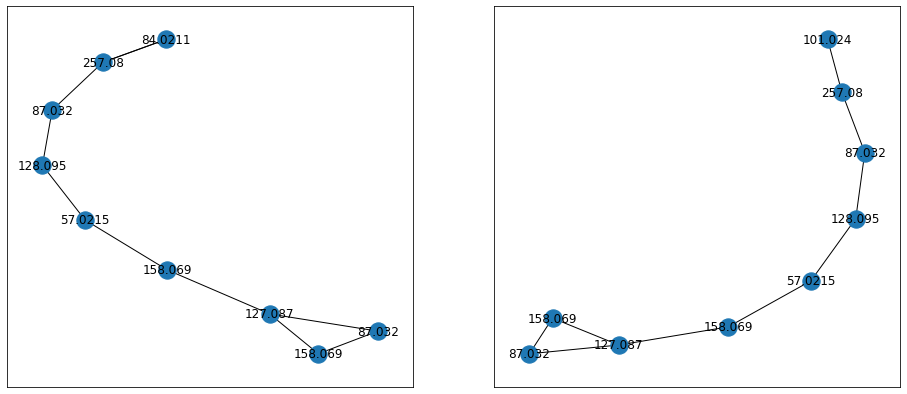

In [35]:
# TEMPORARY

pnp1 = GNPS.nodes[3956]['structure']
pnp2 = GNPS.nodes[996]['structure']

print(pnp1.graph)
print(pnp2.graph)
print(pnp_describe(pnp1))
print(pnp_describe(pnp2))

fig = plt.figure(figsize = (16, 7))
l1 = {}
l2 = {}
for i in range(pnp1.number_of_nodes()):
    l1[i] = pnp1.nodes[i]['mass']
    l2[i] = pnp2.nodes[i]['mass']
subax1 = plt.subplot(121)
nx.draw_networkx(pnp1, labels=l1)
subax2 = plt.subplot(122)
nx.draw_networkx(pnp2, labels=l2)
plt.show()

In [23]:
one_mod['changed_AA_degree'] = None

for index, row in one_mod.iterrows():
    id1, id2 = row[['ID1', 'ID2']]
    pnp1 = GNPS.nodes[id1]['structure']
    pnp2 = GNPS.nodes[id2]['structure']
    gone, gain = row[['GoneAA_mass', 'GainAA_mass']]
    *_, AA_mass1 = pnp_describe(pnp1)
    *_, AA_mass2 = pnp_describe(pnp2)
    if AA_mass1[gone] == 1:
        for i in range(pnp1.number_of_nodes()):
            if pnp1.nodes[i]['mass'] == gone:
                one_mod.loc[index, 'changed_AA_degree'] = -pnp1.degree[i]
    if AA_mass2[gain] == 1:
        for i in range(pnp2.number_of_nodes()):
            if pnp2.nodes[i]['mass'] == gain:
                one_mod.loc[index, 'changed_AA_degree'] = pnp2.degree[i]   

one_mod.head(10)

/tmp/ipykernel_22374/4251961399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_mod['changed_AA_degree'] = None
/home/nikitos/Programs/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,ID1,ID2,DeltaMZ,Cosine,Component,Note,structure_change,GoneAA_mass,GainAA_mass,changed_AA_degree
0,1109,1076,39.011,0.9258,1,C2HN,No,147.068,186.079,2
1,1041,8,39.011,0.9258,1,C2HN,No,147.068,186.079,-2
3,1076,8,39.011,0.9258,1,C2HN,No,147.068,186.079,-2
4,1109,1041,39.011,0.9258,1,C2HN,No,147.068,186.079,2
7,4646,4656,14.010,0.7778,2,tertiary amine:N:methanol (-H2O):CH2,No,85.0528,99.0684,None
9,4647,4653,14.010,1.0000,2,tertiary amine:N:methanol (-H2O):CH2,No,85.0528,99.0684,None
10,4647,4656,14.010,1.0000,2,tertiary amine:N:methanol (-H2O):CH2,No,85.0528,99.0684,None
11,4710,4717,14.020,1.0000,2,tertiary amine:N:methanol (-H2O):CH2,No,85.0528,99.0684,None
13,4614,4627,14.020,0.8333,2,tertiary amine:N:methanol (-H2O):CH2,No,99.0684,113.084,None
15,4584,4575,2.020,1.0000,2,H2,No,100.076,102.092,1


In [24]:
one_mod.groupby(['changed_AA_degree', 'structure_change'], dropna=False).count()

ID1   ID2  DeltaMZ  Cosine  \
changed_AA_degree structure_change                                        
-3.0              No                           1     1        1       1   
-2.0              No                         427   427      427     427   
-1.0              No                          26    26       26      26   
 1.0              No                        1816  1816     1816    1816   
                  branch-cyclic -> linear      5     5        5       5   
                  complex -> branch-cyclic    13    13       13      13   
 2.0              No                        3216  3216     3216    3216   
                  branch-cyclic -> linear      2     2        2       2   
 3.0              No                         193   193      193     193   
 4.0              No                          73    73       73      73   
 5.0              No                           1     1        1       1   
 6.0              No                           3     3        3       3   
 8.0              No                           1     1        1       1   
 NaN              No                         569   569      569     569   

                                            Component  Note  GoneAA_mass  \
changed_AA_degree structure_change                                         
-3.0              No                                1     1            1   
-2.0              No                              427   427          427   
-1.0              No                               26    26           26   
 1.0              No                             1816  1816         1816   
                  branch-cyclic -> linear           5     5            5   
                  complex -> branch-cyclic         13    13           13   
 2.0              No                             3216  3216         3216   
                  branch-cyclic -> linear           2     2            2   
 3.0              No                              193   193          193   
 4.0              No                               73    73           73   
 5.0              No                                1     1            1   
 6.0              No                                3     3            3   
 8.0              No                                1     1            1   
 NaN              No                              569   569          569   

                                            GainAA_mass  
changed_AA_degree structure_change                       
-3.0              No                                  1  
-2.0              No                                427  
-1.0              No                                 26  
 1.0              No                               1816  
                  branch-cyclic -> linear             5  
                  complex -> branch-cyclic           13  
 2.0              No                               3216  
                  branch-cyclic -> linear             2  
 3.0              No                                193  
 4.0              No                                 73  
 5.0              No                                  1  
 6.0              No                                  3  
 8.0              No                                  1  
 NaN              No                                569

## Modifications with zero mass change

In [25]:
invisible_mods = edges[(edges.GoneAA_mass == 0) & (edges.GainAA_mass == 0)]
invisible_mods = invisible_mods.drop(columns=['GoneAA_mass', 'GainAA_mass'])

In [26]:
invisible_mods.groupby(['structure_change']).count()

,ID1,ID2,DeltaMZ,Cosine,Component,Note
structure_change,,,,,,
No,139,139,139,139,139,139


In [27]:
invisible_mods = invisible_mods.drop(columns=['structure_change'])

In [28]:
def AA_mass_match(n1, n2):
    return n1['mass'] == n2['mass']

for index, row in invisible_mods.iterrows():
    id1, id2 = row[['ID1', 'ID2']]
    pnp1 = GNPS.nodes[id1]['structure']
    pnp2 = GNPS.nodes[id2]['structure']
    invisible_mods.loc[index, 'isomorphism'] = nx.is_isomorphic(pnp1, pnp2, node_match=AA_mass_match)

invisible_mods

,ID1,ID2,DeltaMZ,Cosine,Component,Note,isomorphism
2,1076,1041,0.0,0.8571,1,,False
12,4578,4575,0.0,0.8889,2,,False
40,4647,4645,0.0,0.8889,2,,False
56,4718,4717,0.0,0.8333,2,,False
57,4566,4559,0.0,0.8333,2,,False
...,...,...,...,...,...,...,...
13976,4303,4300,0.0,0.7692,289,,False
14445,3507,2528,0.0,1.0000,349,,True
14659,5011,1172,0.0,0.8416,412,,False
14696,3041,2110,0.0,0.9364,428,,False


In [29]:
invisible_mods.groupby(['isomorphism']).count()

,ID1,ID2,DeltaMZ,Cosine,Component,Note
isomorphism,,,,,,
False,137,137,137,137,137,137
True,2,2,2,2,2,2


{'file': 'mols/QYK92-E.mol', 'name': 'Xantholysin_A_Xantholysin_A', 'formula': 'C84H146N18O23', 'mass': 1775.08, 'multiedges': False, 'structure': 'branch-cyclic'}
{'file': 'mols/QYL64-C.mol', 'name': 'Antibiotic_MA_026_Antibiotic_MA_026', 'formula': 'C84H146N18O23', 'mass': 1775.08, 'multiedges': False, 'structure': 'branch-cyclic'}
(15, 1775.08, 'C84H146N18O23', Counter({'C6H11NO': 6, 'C5H8N2O2': 4, 'C5H9NO': 2, 'C10H19O2': 1, 'C5H7NO3': 1, 'C3H4NO2': 1}), Counter({113.084: 6, 128.059: 4, 99.0684: 2, 171.139: 1, 129.043: 1, 86.0242: 1}))
(15, 1775.08, 'C84H146N18O23', Counter({'C6H11NO': 6, 'C5H8N2O2': 4, 'C5H9NO': 2, 'C10H19O2': 1, 'C5H7NO3': 1, 'C3H4NO2': 1}), Counter({113.084: 6, 128.059: 4, 99.0684: 2, 171.139: 1, 129.043: 1, 86.0242: 1}))


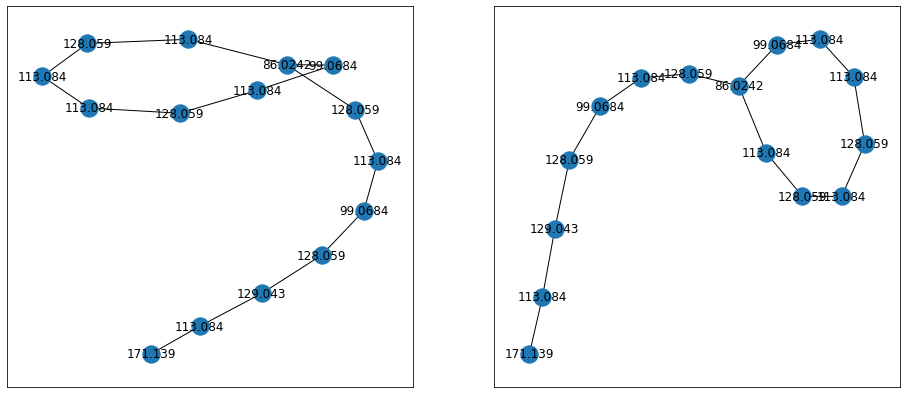

In [32]:
# TEMPORARY

pnp1 = GNPS.nodes[3041]['structure']
pnp2 = GNPS.nodes[2110]['structure']

print(pnp1.graph)
print(pnp2.graph)
print(pnp_describe(pnp1))
print(pnp_describe(pnp2))

fig = plt.figure(figsize = (16, 7))
l1 = {}
l2 = {}
for i in range(pnp1.number_of_nodes()):
    l1[i] = pnp1.nodes[i]['mass']
    l2[i] = pnp2.nodes[i]['mass']
subax1 = plt.subplot(121)
nx.draw_networkx(pnp1, labels=l1)
subax2 = plt.subplot(122)
nx.draw_networkx(pnp2, labels=l2)
plt.show()

### 

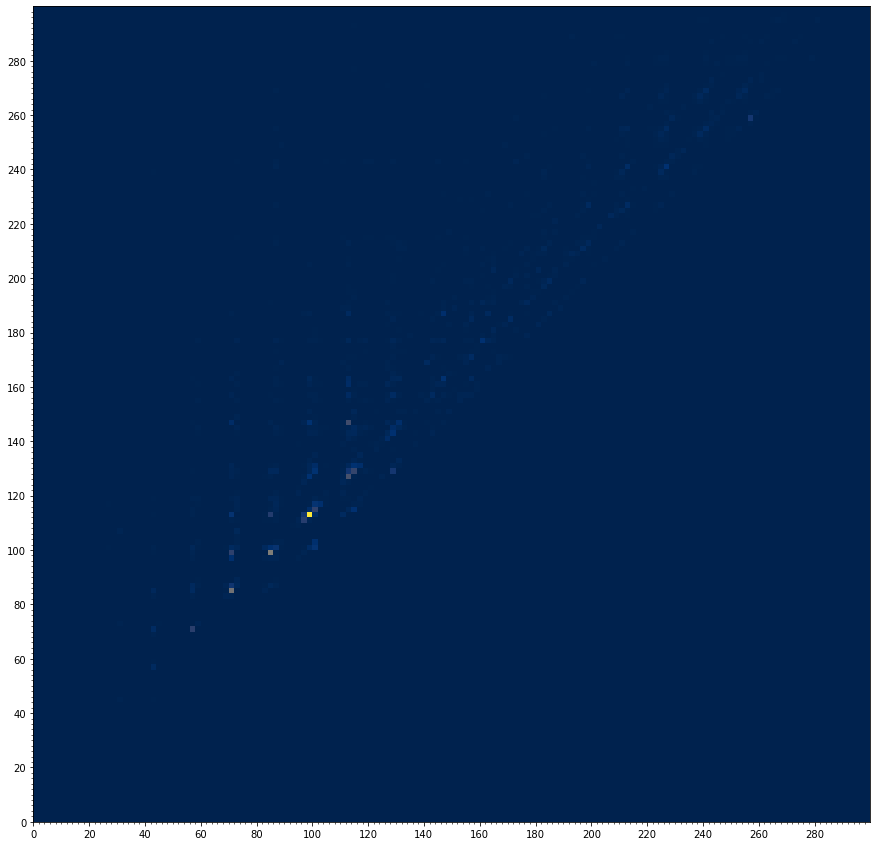

In [30]:
xmin, xmax = 0, 300
ymin, ymax = 0, 300
xstep = ystep = 2

fig = plt.figure(figsize = ((xmax - xmin) // 20, (ymax - ymin) // 20))
ax = fig.add_subplot()
xmajor_ticks = np.arange(xmin, xmax, 10 * xstep)
xminor_ticks = np.arange(xmin, xmax, xstep)
ymajor_ticks = np.arange(ymin, ymax, 10 * ystep)
yminor_ticks = np.arange(ymin, ymax, ystep)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

plt.hist2d(one_mod.GoneAA_mass, one_mod.GainAA_mass,
           bins=[(xmax - xmin) // xstep, (ymax - ymin) // ystep],
           range=[[xmin, xmax], [ymin, ymax]], cmap='cividis')
plt.show()

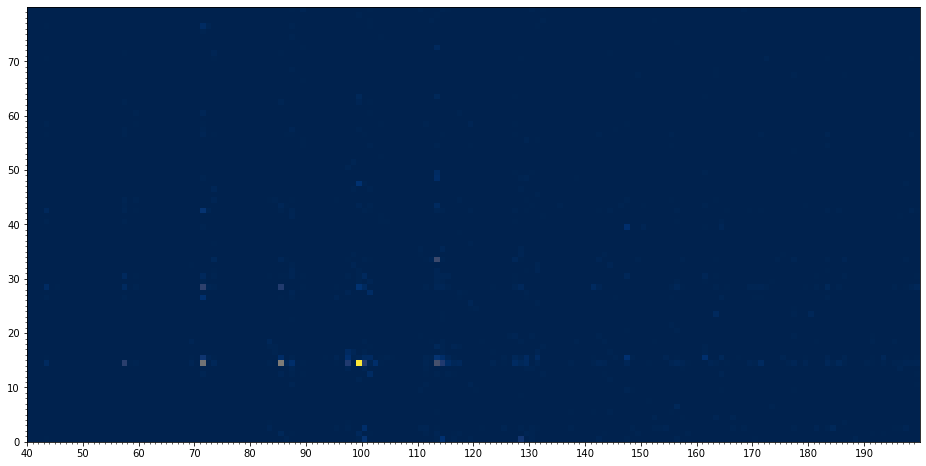

In [31]:
xmin, xmax = 40, 200
ymin, ymax = 0, 80
xstep = ystep = 1

fig = plt.figure(figsize = ((xmax - xmin) // 10, (ymax - ymin) // 10))
ax = fig.add_subplot()
xmajor_ticks = np.arange(xmin, xmax, 10 * xstep)
xminor_ticks = np.arange(xmin, xmax, xstep)
ymajor_ticks = np.arange(ymin, ymax, 10 * ystep)
yminor_ticks = np.arange(ymin, ymax, ystep)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

plt.hist2d(one_mod.GoneAA_mass, one_mod.GainAA_mass - one_mod.GoneAA_mass,
           bins=[(xmax - xmin) // xstep, (ymax - ymin) // ystep],
           range=[[xmin, xmax], [ymin, ymax]], cmap='cividis')
plt.show()

In [32]:
AA_changing = []
for i in range(len(one_mod)):
    AA = list(one_mod.iloc[i][['GoneAA_mass', 'GainAA_mass']].values)
    AA = ' '.join([str(_) for _ in AA])
    AA_changing.append(AA)

Counter(AA_changing).most_common()

[('99.0684 113.084', 373),
 ('85.0528 99.0684', 189),
 ('71.0371 85.0528', 150),
 ('113.084 127.1', 84),
 ('113.084 147.068', 76),
 ('71.0371 99.0684', 63),
 ('57.0215 71.0371', 53),
 ('100.052 114.068', 52),
 ('85.0528 113.084', 51),
 ('97.0528 111.068', 51),
 ('128.059 129.043', 42),
 ('71.0371 87.032', 41),
 ('257.08 258.088', 39),
 ('114.043 128.059', 35),
 ('100.04 101.024', 34),
 ('71.0371 113.084', 30),
 ('99.0684 147.068', 29),
 ('99.0684 127.1', 28),
 ('114.043 115.027', 27),
 ('161.084 177.079', 27),
 ('71.0371 97.0528', 27),
 ('97.0528 113.048', 26),
 ('147.068 186.079', 25),
 ('102.092 116.108', 25),
 ('147.068 163.063', 25),
 ('100.076 102.092', 24),
 ('113.084 161.084', 21),
 ('226.193 240.209', 19),
 ('115.027 129.043', 19),
 ('71.0497 85.0653', 18),
 ('71.0371 147.068', 18),
 ('113.084 129.079', 18),
 ('212.178 240.209', 18),
 ('101.024 129.019', 18),
 ('113.084 163.063', 18),
 ('87.032 101.048', 17),
 ('85.0528 101.048', 17),
 ('97.0528 113.084', 16),
 ('43.0184 71.049

# Let's try to work with real data

In [2]:
real_spectra = pd.read_csv("../gnps_positive_MH_unique/gnps_positive_MH_unique.tsv", sep='\t')
real_spectra = real_spectra.drop(columns=["ms_level", "charge", "instrument"])
real_spectra

,spectrum_id,precursor_mz,parent_mass,compound_name,adduct,inchikey,formula_smiles,smiles,inchi14
0,CCMSLIB00005466011,505.986,504.978724,purealidin X,M+H,MVEVFOAVVITDMF-FOKLQQMPSA-N,C16H19Br2N5O4,COC1=C(Br)C(O)=C(C/C(C(NCCCC(N2)=CNC2=N)=O)=N\...,MVEVFOAVVITDMF
1,CCMSLIB00000563358,766.600,765.592724,Triacylglycerol 10:0-16:0-18:1,[M+NH4]+,FWWKWLAGVGBURZ-NMSHJFGGSA-N,C47H88O6,CCCCCCCCCCCCC/C=C\CCC(=O)OCC(COC(=O)CCCCCCCCC)...,FWWKWLAGVGBURZ
2,CCMSLIB00003112629,833.593,832.585724,PC(18:2/22:4),M+H,PNFUIOJRSUFFPH-VYFLHTJVSA-N,NaN,CCCCC/C=C\C/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O...,PNFUIOJRSUFFPH
3,CCMSLIB00000846330,271.154,270.146724,"6-(2,4-dihydroxy-3,5-dimethylhexyl)-4-hydroxy-...",M+H,JQHCHMRMIDGIBW-UHFFFAOYSA-N,C14H22O5,CC(C)C(O)C(C)C(O)CC1=CC(O)=C(C)C(=O)O1,JQHCHMRMIDGIBW
4,CCMSLIB00000077192,305.249,304.241724,Arachidonic_acid,M+H,YZXBAPSDXZZRGB-UHFFFAOYSA-N,C20H32O2,CCCCCC=CCC=CCC=CCC=CCCCC(=O)O,YZXBAPSDXZZRGB
...,...,...,...,...,...,...,...,...,...
11836,CCMSLIB00000577636,1037.490,1036.482724,WS-9320-A_32405_dereplictor_pv_1.29701e-19,M+H,AFSBZKIQRMKPNF-ZIAXUAQSSA-N,C54H68N8O13,[H]OC1=C([H])C([H])=C(\C([H])=C2/N(C(=O)C([H])...,AFSBZKIQRMKPNF
11837,CCMSLIB00000424987,561.126,560.118724,Dictazoline C,M+H,FCLRMHVOEFMMCX-RRWZXMNXSA-N,C26H23BrN8O2,O=C(N(C)C(N1C)=N)[C@@]1([C@@H](C2=CNC3=C2C=CC=...,FCLRMHVOEFMMCX
11838,CCMSLIB00000085537,789.876,788.868724,Metrizamide31112-62-6,M+H,BAQCROVBDNBEEB-UBYUBLNFSA-N,C18H22I3N3O8,CN(C(=O)C)c1c(I)c(NC(=O)C)c(I)c(C(=O)N[C@H]2C(...,BAQCROVBDNBEEB
11839,CCMSLIB00000078405,309.054,308.046724,Nimesulide,[M+H],HYWYRSMBCFDLJT-UHFFFAOYSA-N,C13H12N2O5S,C1=CC(=CC(=C1NS(=O)(=O)C)OC2=CC=CC=C2)[N+](=O)...,HYWYRSMBCFDLJT


In [24]:
adducts_distrib = real_spectra.groupby(["adduct"]).spectrum_id.count().sort_values(ascending=False)
adducts_distrib[adducts_distrib > 2]

adduct
M+H            7625
[M+H]+         1167
[M+H]           623
M+NH4           601
M+Na            414
M-H2O+H         300
[M+K]+          296
[M+Na]+         207
[M]+*           102
2M+H             61
[M+NH4]+         56
[M]*+            47
[M+Na]           45
M-H              43
M+H-H2O          36
M+               32
M+K              18
[M+2H]           16
2M+Na            14
[2M+Na]          13
[M+H+CH3OH]      13
[M-H2O+H]+        9
M+ACN+H           9
[M]+              9
[2M+H]            7
Cat               7
[M-H]-            7
[M+NH4]           7
[2M+NH4]          6
[M+2H]2+          5
[M+2H]++          5
Name: spectrum_id, dtype: int64

In [ ]:
real_spectra_answers = real_spectra[["spectrum_id", "compound_name", "inchikey"]]
real_spectra_answers.set_index(real_spectra.inchi14, inplace=True)
real_spectra_answers

In [ ]:
real_spectra.describe()

In [38]:
GNPS.nodes[1]['structure'].graph

{'file': 'mols/PKQ00-A.mol',
 'name': 'Serratamolide_E_Serratamolide_E',
 'formula': 'C24H42N2O8',
 'mass': 486.294,
 'multiedges': False,
 'structure': 'cyclic'}

In [ ]:
for index, row in tqdm(real_spectra.iterrows()):
    for pnp_id in range(1, 5022):
        if abs(GNPS.nodes[pnp_id]['structure'].graph['mass'] - row["parent_mass"]) < 2e-2:
            print(row["compound_name"], GNPS.nodes[pnp_id]['structure'].graph['name'], sep="\n", end="\n\n")

In [3]:
path_to_matches = "../dereplicator_output/"

In [48]:
all_matches = pd.read_csv(path_to_matches + "all_matches.tsv", sep='\t')
all_matches.drop(columns=["SpecFile", "LocalSpecIdx", "Retention", "Adduct", "Charge"], inplace=True)
all_matches

,Scan,LocalPeptideIdx,Name,Score,P-Value,PeptideMass,SpectrumMass
0,5253,2046,Laxaphycin_A_Laxaphycin_A,40,2.600000e-77,1195.720,1196.730
1,5111,1133,Barangamides_Barangamide_A,33,1.200000e-55,1091.730,1092.740
2,3784,3493,E'Surugamide_B',31,2.000000e-71,897.605,898.620
3,8304,1947,"Cyclosporin,_9CI_Cyclosporin_B",31,7.800000e-60,1187.830,1188.840
4,1250,2384,Telomycin_Telomycin,31,1.300000e-64,1271.550,1272.560
...,...,...,...,...,...,...,...
351,5229,2508,Tunicyclin_D_Tunicyclin_D,3,1.000000e+00,900.461,901.479
352,1720,795,N-β-Alanyltyrosine_Z-β-Ala-Tyr-OMe,3,1.000000e+00,400.163,401.159
353,5875,1871,Hoiamide_A_Hoiamide_A,3,1.000000e+00,925.436,926.458
354,10506,3149,HC_Toxin_I_3''β-Hydroxy,3,1.000000e+00,452.227,453.250


In [49]:
all_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Scan             356 non-null    int64  
 1   LocalPeptideIdx  356 non-null    int64  
 2   Name             356 non-null    object 
 3   Score            356 non-null    int64  
 4   P-Value          356 non-null    float64
 5   PeptideMass      356 non-null    float64
 6   SpectrumMass     356 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 19.6+ KB


In [4]:
significant_matches = pd.read_csv(path_to_matches + "significant_matches.tsv", sep='\t')
significant_matches.drop(columns=["VisualizationID", "SpecFile", "LocalSpecIdx", 
                                  "Retention", "Adduct", "Charge"], inplace=True)
significant_matches

,Scan,LocalPeptideIdx,Name,Score,P-Value,PeptideMass,SpectrumMass,SMILES
0,5253,2046,Laxaphycin_A_Laxaphycin_A,40,2.600000e-77,1195.720,1196.730,CCCCCC1CC(=O)NC(CCO)C(=O)NC(=CC)C(=O)N2CC(CC2C...
1,3784,3493,E'Surugamide_B',31,2.000000e-71,897.605,898.620,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
2,6671,3495,E'Surugamide_D',30,4.000000e-68,897.605,898.630,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
3,1250,2384,Telomycin_Telomycin,31,1.300000e-64,1271.550,1272.560,CC(C)C(C1C(=O)N2CCC(C2C(=O)OC(C)C(C(=O)NC(C(C)...
4,712,3493,E'Surugamide_B',28,1.600000e-64,897.605,898.630,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
...,...,...,...,...,...,...,...,...
279,2400,325,Versicotide_A_Versicotide_A,6,2.300000e-12,479.217,480.220,CC1C(=O)N(C)C(C)C(=O)Nc2ccccc2C(=O)N(C)C(C)C(=...
280,10420,511,Rakicidin_B_Rakicidin_B,6,3.200000e-12,620.415,621.422,CC(C)CCCCCCCCCCCCC(C)C1C(C)C(=O)NC(=C)C=CC(=O)...
281,10525,979,"Destruxins_2-Valine_analogue,_5'-carboxylic_acid",7,2.300000e-11,609.337,610.335,CC(C)C1C(=O)N(C)C(C(C)C)C(=O)N(C)C(C)C(=O)NCCC...
282,1139,659,Antibiotic_WIN_66306_Antibiotic_WIN_66306,7,5.900000e-11,800.386,801.393,CC(=CCc1cc(ccc1O)C(C1C(=O)NCC(=O)NC(Cc2c[nH]c3...


In [74]:
temp_df = significant_matches.groupby(["Name"]).count()
temp_df[temp_df.Scan > 1]

,Scan,LocalPeptideIdx,Score,P-Value,PeptideMass,SpectrumMass,SMILES
Name,,,,,,,
Acuminatum_Acuminatum_B,2,2,2,2,2,2,2
Antibiotic_WIN_66306_Antibiotic_WIN_66306,2,2,2,2,2,2,2
Aspergillicin_A_Aspergillicin_A,2,2,2,2,2,2,2
Bursaphelocide_B_Bursaphelocide_B,2,2,2,2,2,2,2
"Cyclosporin,_9CI_9-(N-Methyl-L-isoleucine)_analogue",2,2,2,2,2,2,2
Daitocidin_Pumilacidin_F,2,2,2,2,2,2,2
"Destruxins_Piperidine_homologue,_4',5'-dihydro,_4'ξ,5'-dihydroxy",2,2,2,2,2,2,2
E'Surugamide_B',2,2,2,2,2,2,2
Enniatins_Enniatin_G,2,2,2,2,2,2,2


In [53]:
significant_unique_matches = pd.read_csv(path_to_matches + "significant_unique_matches.tsv", sep='\t')
significant_unique_matches.drop(columns=["VisualizationID", "SpecFile", "LocalSpecIdx", 
                                  "Retention", "Adduct", "Charge"], inplace=True)
significant_unique_matches

,Scan,LocalPeptideIdx,Name,Score,P-Value,PeptideMass,SpectrumMass,SMILES
0,5253,2046,Laxaphycin_A_Laxaphycin_A,40,2.600000e-77,1195.720,1196.730,CCCCCC1CC(=O)NC(CCO)C(=O)NC(=CC)C(=O)N2CC(CC2C...
1,3784,3493,E'Surugamide_B',31,2.000000e-71,897.605,898.620,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
2,6671,3495,E'Surugamide_D',30,4.000000e-68,897.605,898.630,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
3,1250,2384,Telomycin_Telomycin,31,1.300000e-64,1271.550,1272.560,CC(C)C(C1C(=O)N2CCC(C2C(=O)OC(C)C(C(=O)NC(C(C)...
4,2277,3494,E'Surugamide_C',27,1.500000e-60,897.605,898.630,NCCCC[C@@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@...
...,...,...,...,...,...,...,...,...
260,2020,472,Destruxins_NVal-De-Me,6,1.300000e-12,563.332,564.341,C=CCC1C(=O)N2CCCC2C(=O)NC(C(C)CC)C(=O)NC(C(C)C...
261,2400,325,Versicotide_A_Versicotide_A,6,2.300000e-12,479.217,480.220,CC1C(=O)N(C)C(C)C(=O)Nc2ccccc2C(=O)N(C)C(C)C(=...
262,10420,511,Rakicidin_B_Rakicidin_B,6,3.200000e-12,620.415,621.422,CC(C)CCCCCCCCCCCCC(C)C1C(C)C(=O)NC(=C)C=CC(=O)...
263,10525,979,"Destruxins_2-Valine_analogue,_5'-carboxylic_acid",7,2.300000e-11,609.337,610.335,CC(C)C1C(=O)N(C)C(C(C)C)C(=O)N(C)C(C)C(=O)NCCC...


In [7]:
matches = significant_matches

In [5]:
real_spectra.iloc[5253]

spectrum_id                                      CCMSLIB00000577491
precursor_mz                                                1196.73
parent_mass                                             1195.722724
compound_name        hormothamnin_A_08432_dereplictor_pv_2.1002e-63
adduct                                                          M+H
inchikey                                AQBJITSSPIIUAM-RSBFCROKSA-N
formula_smiles                                         C60H97N11O14
smiles            [H]OC([H])([H])C([H])([H])[C@]1([H])N([H])C(=O...
inchi14                                              AQBJITSSPIIUAM
Name: 5253, dtype: object

In [24]:
GNPS.nodes[2046 + 1]["structure"].graph

{'file': 'mols/LDF62-C.mol',
 'name': 'Laxaphycin_A_Laxaphycin_A',
 'formula': 'C60H97N11O14',
 'mass': 1195.72,
 'multiedges': False,
 'structure': 'cyclic'}

In [23]:
real_spectra.iloc[matches.Scan]["inchi14"]

5253     AQBJITSSPIIUAM
3784     IEWHPTFFMRBBPQ
6671     POJKUXRIPCIWMZ
1250     KPBHKOJJGBSCIK
712      IMJOKVCCAPZUEO
              ...      
2400     SRHCZSHNDDEHKH
10420    AKYUFOZFLOQQQL
10525    RXOMDRQVYULRRU
1139     LIHVMLWWVHJRMA
5933     RCQTVEFBFUNTGM
Name: inchi14, Length: 284, dtype: object

In [34]:
Chem.MolToInchiKey(Chem.MolFromMolFile("pnpdatabase/" + GNPS.nodes[2046 + 1]["structure"].graph["file"]))

'AQBJITSSPIIUAM-UHFFFAOYSA-N'

In [38]:
bool_mask = []

for index, row in matches.iterrows():
    if real_spectra.iloc[row.Scan]["inchi14"] == Chem.MolToInchiKey(Chem.MolFromMolFile("pnpdatabase/" + GNPS.nodes[row.LocalPeptideIdx + 1]["structure"].graph["file"]))[:14]:
        bool_mask.append(True)
    else:
        bool_mask.append(False)

matches[bool_mask]

# matches[real_spectra.iloc[matches.Scan]["inchi14"] == 
#         Chem.MolToInchiKey(Chem.MolFromMolFile("pnpdatabase/" + GNPS.nodes[matches.LocalPeptideIdx + 1]["structure"].graph["file"]))[:14]]

,Scan,LocalPeptideIdx,Name,Score,P-Value,PeptideMass,SpectrumMass,SMILES
0,5253,2046,Laxaphycin_A_Laxaphycin_A,40,2.600000e-77,1195.720,1196.730,CCCCCC1CC(=O)NC(CCO)C(=O)NC(=CC)C(=O)N2CC(CC2C...
1,3784,3493,E'Surugamide_B',31,2.000000e-71,897.605,898.620,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
2,6671,3495,E'Surugamide_D',30,4.000000e-68,897.605,898.630,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
5,2277,3494,E'Surugamide_C',27,1.500000e-60,897.605,898.630,NCCCC[C@@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@...
8,717,2080,"Cyclosporin,_9CI_Cyclosporin_E",29,1.700000e-56,1187.830,1188.830,CC=CCC(C)C(C1C(=O)NC(CC)C(=O)N(C)CC(=O)N(C)C(C...
...,...,...,...,...,...,...,...,...
277,8739,412,Antibiotic_WIN_68577_Antibiotic_WIN_68577,8,1.200000e-12,732.323,733.330,CC(C)C1C(=O)NCC(=O)NC(C(c2ccc(cc2)O)O)C(=O)NCC...
278,2020,472,Destruxins_NVal-De-Me,6,1.300000e-12,563.332,564.341,C=CCC1C(=O)N2CCCC2C(=O)NC(C(C)CC)C(=O)NC(C(C)C...
279,2400,325,Versicotide_A_Versicotide_A,6,2.300000e-12,479.217,480.220,CC1C(=O)N(C)C(C)C(=O)Nc2ccccc2C(=O)N(C)C(C)C(=...
280,10420,511,Rakicidin_B_Rakicidin_B,6,3.200000e-12,620.415,621.422,CC(C)CCCCCCCCCCCCC(C)C1C(C)C(=O)NC(=C)C=CC(=O)...


In [46]:
missmatches = matches[[not _ for _ in bool_mask]]
missmatches

,Scan,LocalPeptideIdx,Name,Score,P-Value,PeptideMass,SpectrumMass,SMILES
3,1250,2384,Telomycin_Telomycin,31,1.300000e-64,1271.550,1272.560,CC(C)C(C1C(=O)N2CCC(C2C(=O)OC(C)C(C(=O)NC(C(C)...
4,712,3493,E'Surugamide_B',28,1.600000e-64,897.605,898.630,NCCCC[C@H]1NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@...
6,8304,1947,"Cyclosporin,_9CI_Cyclosporin_B",31,7.800000e-60,1187.830,1188.840,CC=CCC(C)C(C1C(=O)NC(C)C(=O)N(C)CC(=O)N(C)C(CC...
7,185,1062,"Cyclosporin,_9CI_9-(N-Methyl-L-isoleucine)_ana...",29,3.000000e-58,1201.840,1202.850,CC=CCC(C)C(C1C(=O)NC(CC)C(=O)N(C)CC(=O)N(C)C(C...
11,3888,4650,theonellapeptolide_VI,31,8.400000e-53,1389.920,1390.940,CC[C@@H]([C@H]1C(=O)N(CCC(=O)N[C@@H](C(=O)N[C@...
...,...,...,...,...,...,...,...,...
257,6438,2310,Hypomurocin_A_Hypomurocin_A2,6,3.300000e-14,1174.770,1175.780,CCC(C)(C(=O)NC(CCC(=N)O)C(=O)NC(C(C)C)C(=O)NC(...
264,11158,1282,Bursaphelocide_A_Bursaphelocide_A,9,9.100000e-14,593.379,594.386,CCC(C)C1C(=O)N(C)C(C(C)C)C(=O)N(C)C(C)C(=O)NCC...
270,9630,1062,"Cyclosporin,_9CI_9-(N-Methyl-L-isoleucine)_ana...",9,2.100000e-13,1201.840,1202.850,CC=CCC(C)C(C1C(=O)NC(CC)C(=O)N(C)CC(=O)N(C)C(C...
281,10525,979,"Destruxins_2-Valine_analogue,_5'-carboxylic_acid",7,2.300000e-11,609.337,610.335,CC(C)C1C(=O)N(C)C(C(C)C)C(=O)N(C)C(C)C(=O)NCCC...
